# Lab 6: Confidence Intervals

## William Olsen, partners with Jennifer Vo

Within this lab we will be using the data from the LHC in order to explore confidence intervals around measuring the Higgs.  This lab will be more focused on exploring the background rather than doing an in-depth exploration for the Higgs.

From work done in the previous lab, we identified that when searching for the Higgs Boson the background distribution at the ATLAS detector at the LHC is a Poisson distribution.  We will be using a Poisson distribution with parameter 100 which is not the same as the true parameter for the distribution but for sake of analysis we will use this parameter.

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pickle

# general graphing setup
plt.rcParams["figure.figsize"] = (15,10)

## Problem 1

Now with our persumed background - a Poisson distribution with parameter 100 - let's determine the $5\sigma$ sensitivity threshold value for our distribution by answering the following question:

> What value must the background distribution - a Poisson with parameter 100 - produce such that the probability of producing that value is 5-sigma?

Let's answer this question:

In [2]:
def compute_poisson_sigma_value(lambda_, value):
    # determine the probability associated with this value
    value_prob = stats.poisson.sf(value, lambda_)

    # use the inverse survival function to determine the sigma that has the same associated probability
    sigma = stats.norm.isf(value_prob)

    return sigma

def compute_poisson_5sigma_value(lambda_):
    # define the sigma value
    sigma = 5

    # use the inverse survival function to determine the probability associated with 5sigma
    prob_sigma = stats.norm.sf(sigma)
    
    # determine the value associated with this probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

In [3]:
# define our variables
bkgd_lambda = 100

# determine the value associated with a 5-sigma probability
bkgd_5sigma_value = compute_poisson_5sigma_value(bkgd_lambda)
print(f'The value required for a 5-sigma probability for the background is {bkgd_5sigma_value}')

The value required for a 5-sigma probability for the background is 154.0


From the above, we found that the $5\sigma$ sensitivity threshold value for our background distribution - a Poisson with parameter 100 - is 154.0.

## Problem 2

Now we will explore injecting a signal of known strength (between the $8\sigma$ and $30\sigma$ values) into our background many times and we will make observations after doing such.

### Part A

Let's create a histogram for how bright the observed signal is after injecting a true signal of strength $8\sigma$ (which is equivalent to the value 190.0) into our background.

In [6]:
def compute_poisson_specific_sigma_value(sigma, lambda_):
    # use the inverse survival function to determine the probability associated with 5sigma
    prob_sigma = stats.norm.sf(sigma)
    
    # determine the value associated with this probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

# define the inject signal
inject_8sigma_value = compute_poisson_specific_sigma_value(8, bkgd_lambda)

# draw from the background many times
draw_bkgd = stats.poisson.rvs(bkgd_lambda, size=1000000)

# inject the signal
bkgd_injected = draw_bkgd + inject_8sigma_value

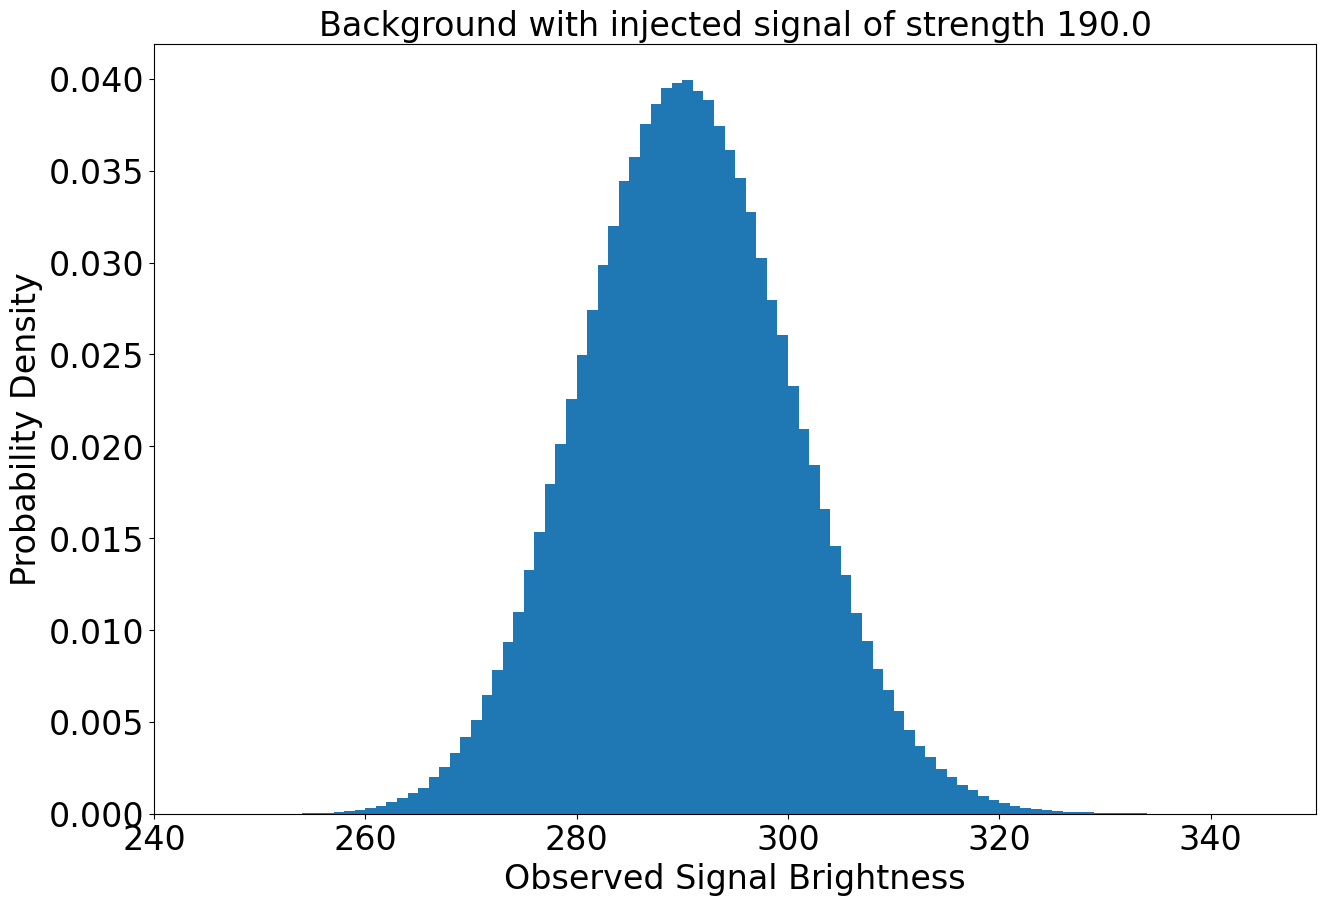

In [7]:
# plot the histogram
fs = 24
bin_count = 96
plt.hist(bkgd_injected, bins=bin_count, density=True)
plt.title(f'Background with injected signal of strength {inject_8sigma_value}', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlabel('Observed Signal Brightness', fontsize=fs)
plt.ylabel('Probability Density', fontsize=fs)
plt.xlim(240, 350)
plt.show()

For the Gaussian distribution, mean = 290.5 and the standard deviation = 10


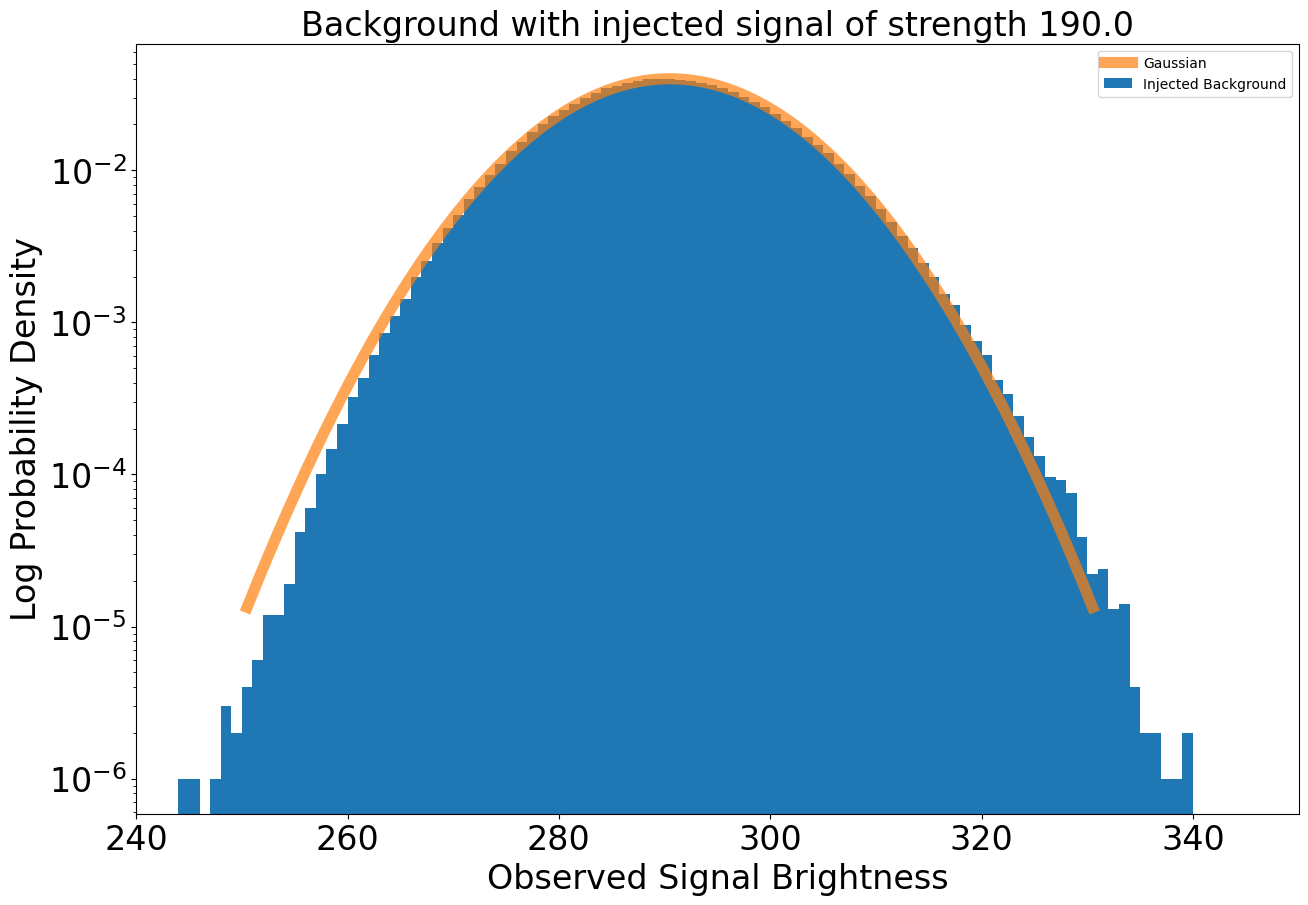

In [8]:
# plot the histogram on log scale
plt.hist(bkgd_injected, bins=bin_count, label='Injected Background', density=True)
plt.title(f'Background with injected signal of strength {inject_8sigma_value}', fontsize=fs)
plt.yscale('log')
plt.tick_params(labelsize=fs)
plt.xlabel('Observed Signal Brightness', fontsize=fs)
plt.ylabel('Log Probability Density', fontsize=fs)
plt.xlim(240, 350)

# plot a gaussian on the same plot
gaus_mean = bkgd_lambda + inject_8sigma_value + 0.5
gaus_range = 40
gaus_std = 10
print(f'For the Gaussian distribution, mean = {gaus_mean} and the standard deviation = {gaus_std}')
gaus_xs = np.linspace(gaus_mean - gaus_range, gaus_mean + gaus_range, 1000)
gaus_ys = stats.norm.pdf(gaus_xs, loc=gaus_mean, scale=gaus_std)
plt.plot(gaus_xs, gaus_ys, linewidth=8, alpha=0.7, label="Gaussian")
plt.legend()

plt.show()

In the above plot we see that the central limit theorem is in play.  We have drawn many samples from our background distribution of a Poisson with parameter 100 that also has a true signal of 190 injected.  In drawing these many samples and creating a histogram we have converged to a Gaussian.  The gaussian that we have converged to has, approximately, a mean of 290.5 and standard deviation of 10.0.

Specifically, the above histogram is telling us the probabilities associated with measuring specific observed signal brightness values provided that we have injected a signal of 190.0 into our experiment.  We see that injecting this signal has moved the mean of our background to no longer be centered around 100 but rather it is now centered around a higher value of, approximately, 290.5.  

The histogram is a probability density function for the observed signal brightness provided an injected signal of magnitude 190.

### Part B

Analyzing the resulting injected distribution further we can conclude that the distribution is biased with respect to the injected signal. All of the values in our distribution have a brightness higher than the brightness of the injected signal - observed values with a brightness larger than the injected signal are much more likely than observed values with a brightness smaller than the injected signal.  Specifically, we see that it is incredibly improbable for the injected distribution to produce the injected signal.  This bias is not suprising as our original background distirbution is a Poisson which can only take on positive values, thus when injecting signals the stronger the injected signal is, the lower the probability will be for the injected distribution to produce said injected signal.

We also have found that the injected distribution is a symmetric distribution as it is a Gaussian.  It is of note that while the distribution is symmetric, it is symmetric about it's mean value of 290.5 rather than symmetric about the injected signal value of 190.0.

## Problem 3

For this problem rather than injecting just one signal into our background we will inject many signals of different strengths where the signal strengths will range from a value of 0 up to a signal strength above $30\sigma$.  We are unable to compute the actual $30\sigma$ value because the probability associated with this value is so small floating point precision prevents us from performing the inverse integral.  For this reason we will use a value that is large enough to represent a signal with strength $30\sigma$ or larger.  We found that the $5\sigma$ value is 154.0 for our distribution thus we will range our injected signal strength from 0 to 330 where the injected signal strength will take on integer values.

### Part A

Let's now simulate the injection of signals ranging from 0 to 330.0.  This simulation will be done by first drawing an ample amount of values from the background distribution - a Poisson with parameter 100 - then once we have done this we will generate the same number of injected signal values where each injected signal is drawn from a uniform random distribution that ranges from 0 to 330.0 and only produces integer values.  This process is exactly us simulating Bayes' Theorem which states: 

$$P(signal | data) = \frac{P(data | signal)P(signal)}{P(data)}$$

We use a uniform random variable for our inject signal to ensure that our prior term - $P(signal)$ - is a constant.  This prevents us from introducting bias into the simulation and thus removes bias from the 2D histogram produced because we have a constant prior.

Generally we would like to analyze $P(signal | data)$ however computing this on its own is quite difficult.  This is why we leverage Bayes' Theorem to create a 2D histogram and then using this 2D histogram we can get the distribution for $P(signal | data)$ by taking a vertical slice on the histogram at some observed signal value.

Overall the simulation we are performing will produce a histogram that allow us to learn what our observed signal distribution and our true signal distribution (or injected signal distribution) will look like by taking horizontal or vertical slices respectively.  Now let's simulate our data and produce a 2D histogram of the results:

In [9]:
# draw data for our background
draw_amount = 30000000
bkgd = stats.poisson.rvs(bkgd_lambda, size=draw_amount)

# draw data for our injected signals
signal_low = 0
signal_high = 330
signal = np.random.uniform(low=signal_low, high=signal_high+1, size=draw_amount)

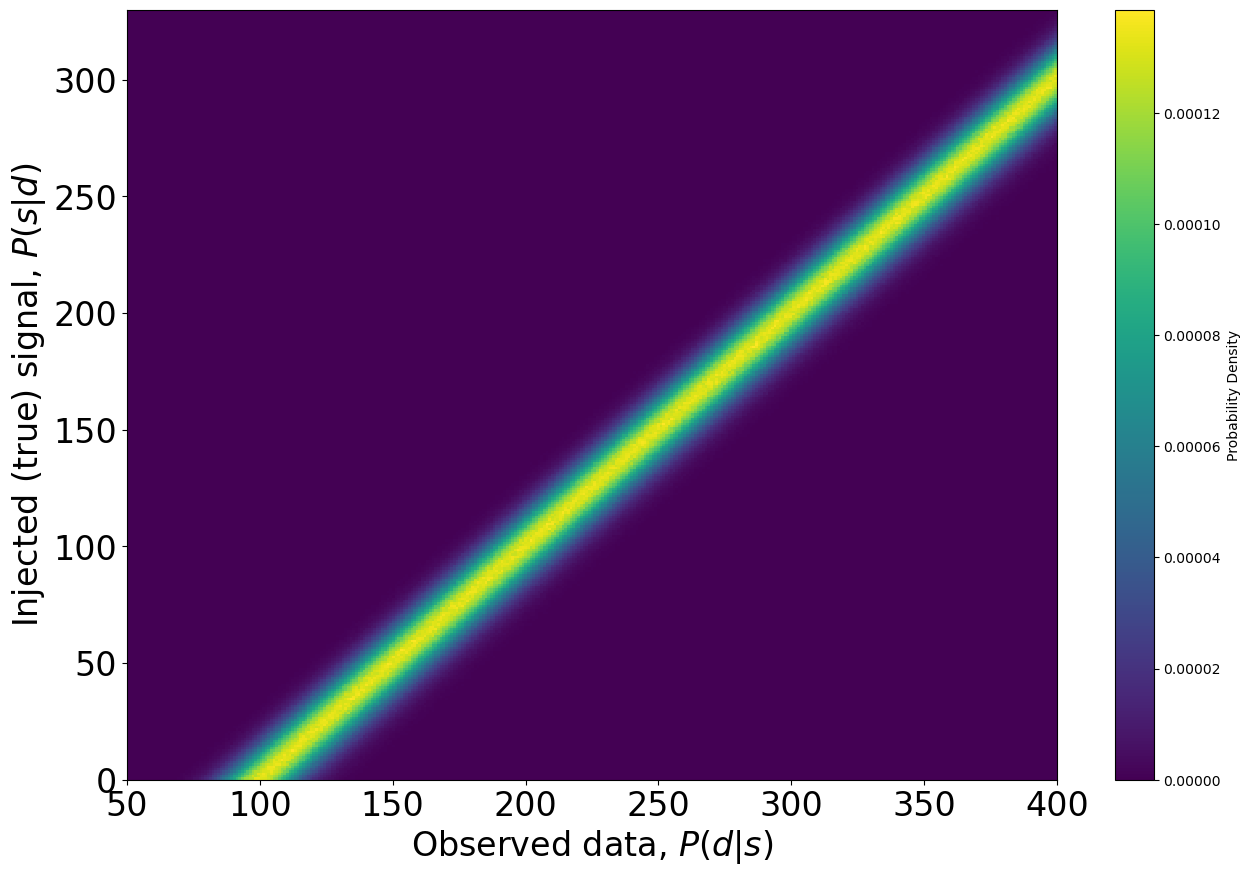

In [10]:
# define our overall data
data = bkgd + signal

# define our bin edges
signaledges = np.linspace(signal_low, signal_high, signal_high - signal_low + 1)
dataedges_min = 50
dataedges_high = signal_high + 70
dataedges = np.linspace(dataedges_min, dataedges_high, dataedges_high - dataedges_min + 2)

# group the results into bins
Psd, temp, temp2 = np.histogram2d(data, signal, bins=[dataedges, signaledges], density=True)
# note: temp == dataedges and temp2 == signaledges

# plot
def plot_2d_hist(signaledges, dataedges, Psd):
    datacenters = (dataedges[:-1] + dataedges[1:]) / 2
    signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
    plt.pcolormesh(datacenters, signalcenters, Psd.T, shading='auto')
    plt.tick_params(labelsize=24)
    plt.ylabel('Injected (true) signal, $P(s|d)$', fontsize = 24)
    plt.xlabel('Observed data, $P(d|s)$', fontsize = 24)
    plt.colorbar(label='Probability Density')
    plt.show()

plot_2d_hist(signaledges, dataedges, Psd)

### Part B

Now that we have done our simluation and created the 2D Histogram we can begin to take vertical and horizontal slices and evaluate the slices in isolation.  Lets take a horizontal slice at the value used in the previous problem, 190.0, and confirm that this horizontal slices produces the same histogram as in the previous problem:

In [11]:
def normalize(vector, width):
    return vector * (1 / (width * np.sum(vector)))

In [12]:
# find the bin associated with the injected value from problem 2
p2_injected_signal_bin_idx = np.digitize(inject_8sigma_value, signaledges) - 1
        
# now that we have the bin for our signal we can get the associated histogram data
p2_observed_data_probs = Psd[:, p2_injected_signal_bin_idx]

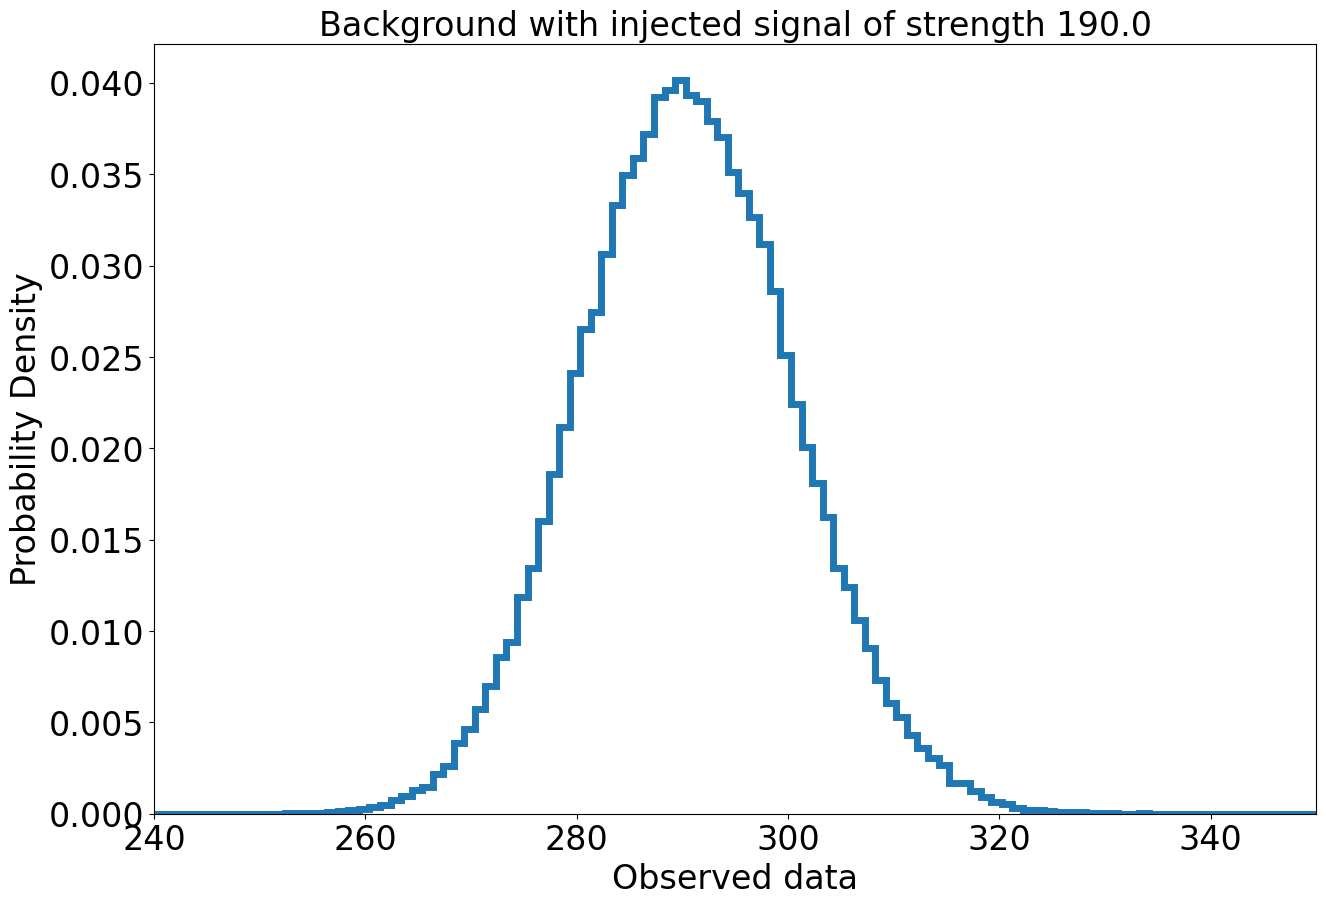

In [13]:
# plot a stair plot
p2_observed_data_probs_normalized = normalize(p2_observed_data_probs, dataedges[1] - dataedges[0])
plt.stairs(p2_observed_data_probs_normalized, dataedges, linewidth=5)
plt.tick_params(labelsize=24)
plt.title(f'Background with injected signal of strength {inject_8sigma_value}', fontsize=24)
plt.xlabel('Observed data', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.xlim(240, 350)
plt.show()

For the Gaussian distribution, mean = 290.5 and the standard deviation = 10


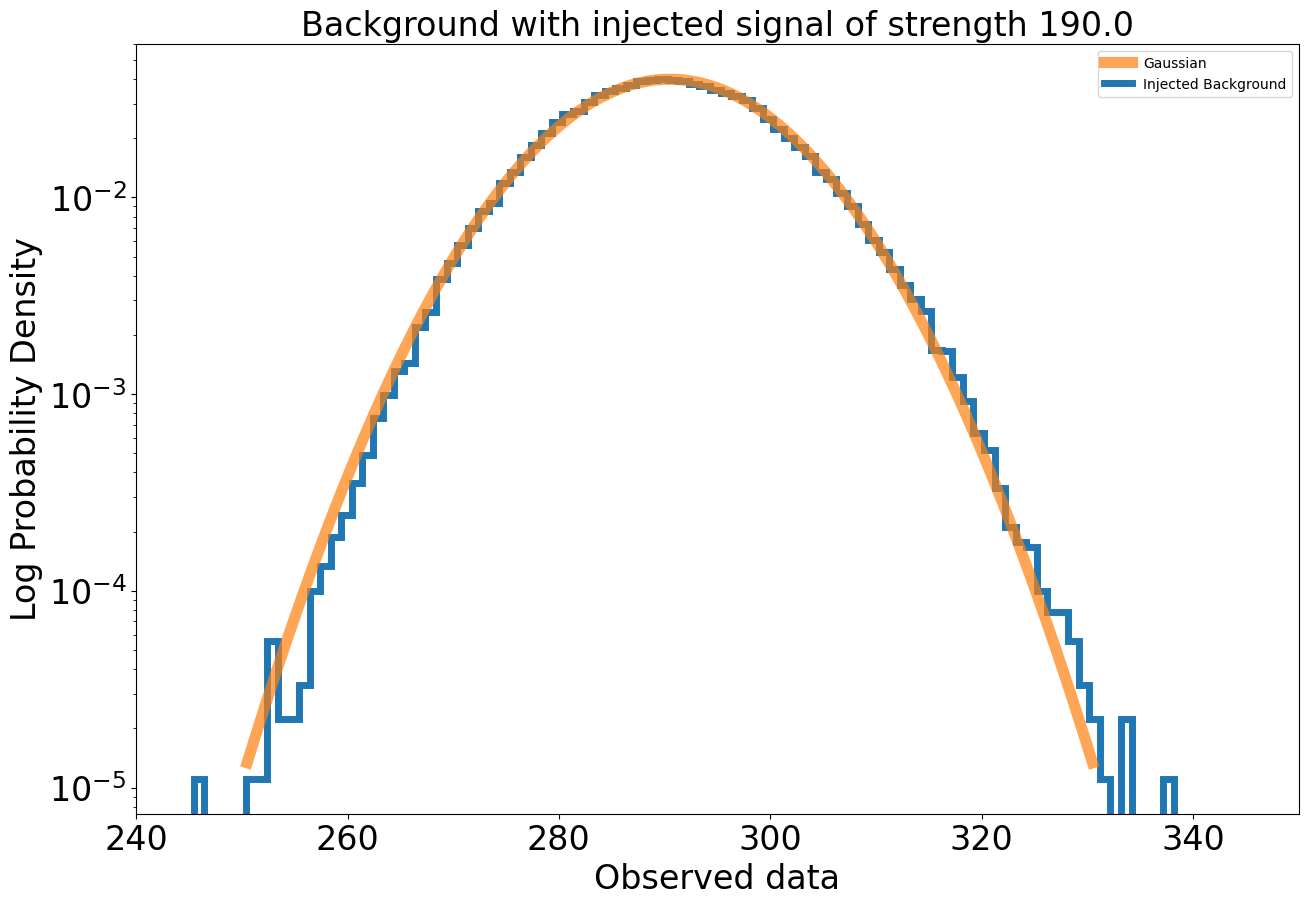

In [14]:
# plot a stair plot
plt.stairs(p2_observed_data_probs_normalized, dataedges, linewidth=5, label='Injected Background')
plt.tick_params(labelsize=24)
plt.yscale('log')
plt.title(f'Background with injected signal of strength {inject_8sigma_value}', fontsize=24)
plt.xlabel('Observed data', fontsize=24)
plt.ylabel('Log Probability Density', fontsize=24)
plt.xlim(240, 350)

gaus_mean = bkgd_lambda + inject_8sigma_value + 0.5
gaus_range = 40
gaus_std = 10
print(f'For the Gaussian distribution, mean = {gaus_mean} and the standard deviation = {gaus_std}')
gaus_xs = np.linspace(gaus_mean - gaus_range, gaus_mean + gaus_range, 1000)
gaus_ys = stats.norm.pdf(gaus_xs, loc=gaus_mean, scale=gaus_std)
plt.plot(gaus_xs, gaus_ys, linewidth=8, alpha=0.7, label="Gaussian")
plt.legend()

plt.show()

From the above plots we can conclude that the horizontal slice histrogram for an injected signal value fo 190.0 is equal to the same histogram produced when solely injecting a signal of 190.0 into the observed data values.  We know that they are approximately the same because both are fit by a Gaussian with the same standard deviation, a value of 10, and the same mean, a value of 290.5.

### Part C

Now let's reverse the problem and perform a vertical slice rather than a horzontal slice to see what probabilities are associated with injected signal (or true signal) values provided some observed data value.  We will select an observed data vaue well above the $5\sigma$ value of 154.0 and this value will be 240.0.  Now let's take our vertical slice:

In [15]:
# define the observed data value at which we are slicing
observed_data_value = 240.0

# find the bin associated with observed data value
observed_data_value_bin_idex = np.digitize(observed_data_value, dataedges) - 1
        
# now that we have the bin for our signal we can get the associated histogram data
true_signal_probs = Psd[observed_data_value_bin_idex, :]

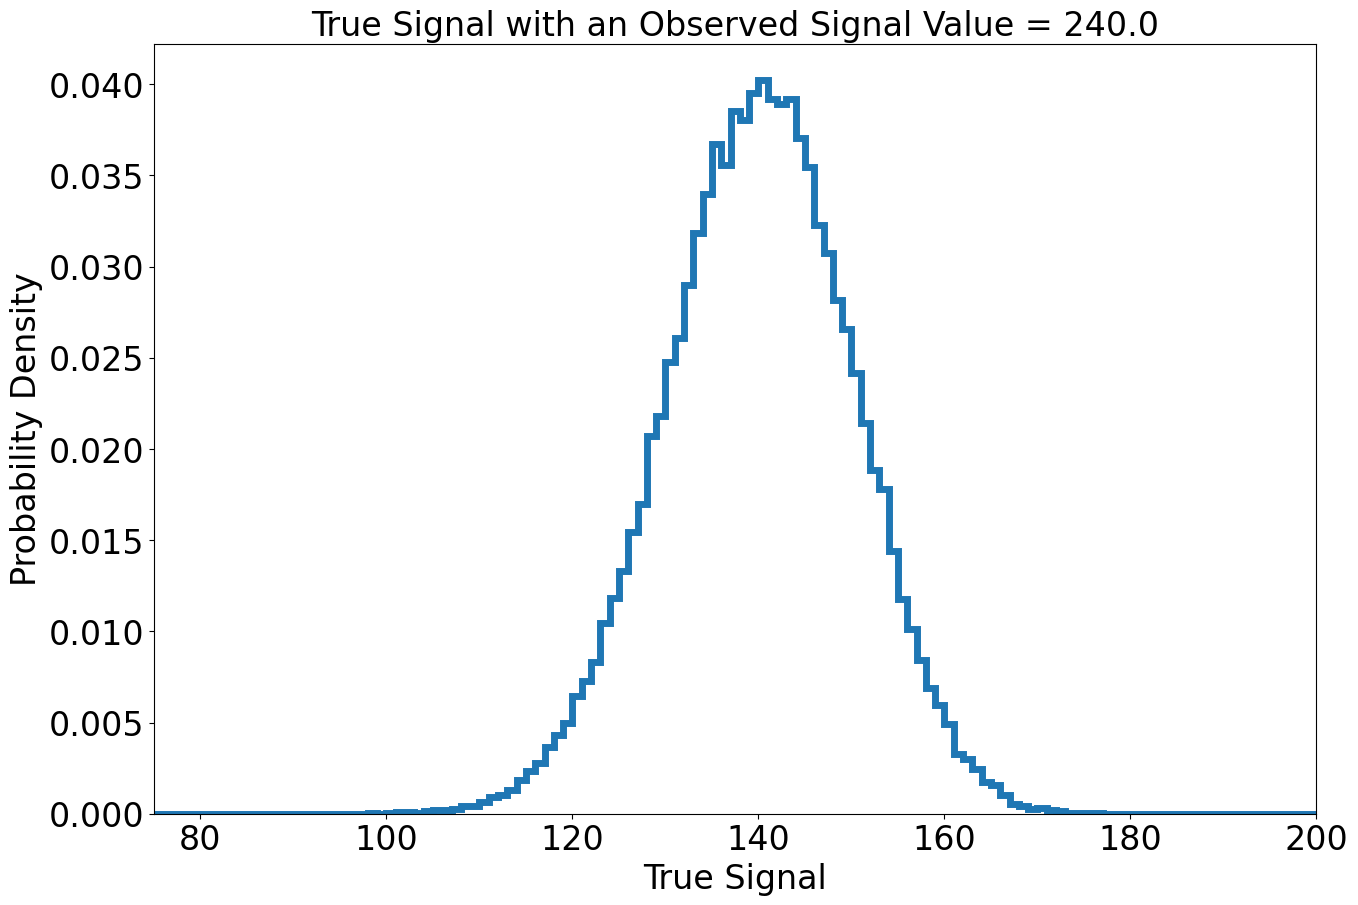

In [16]:
# plot a stair plot
true_signal_probs_normalized = normalize(true_signal_probs, signaledges[1] - signaledges[0])
plt.stairs(true_signal_probs_normalized, signaledges, linewidth=5)
plt.tick_params(labelsize=24)
plt.title(f'True Signal with an Observed Signal Value = {observed_data_value}', fontsize=24)
plt.xlabel('True Signal', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.xlim(75, 200)
plt.show()

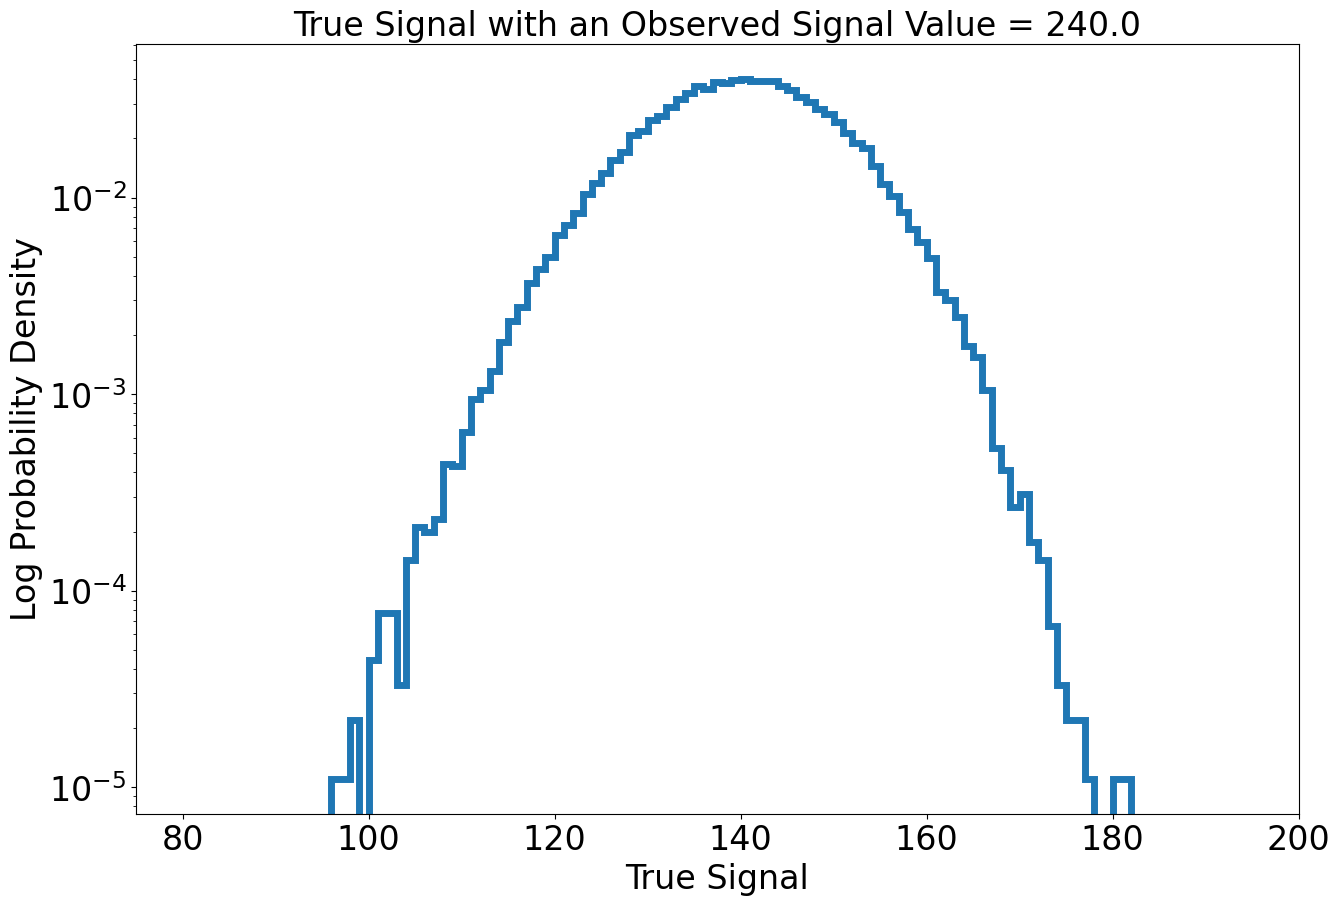

In [17]:
# plot a stair plot
plt.stairs(true_signal_probs_normalized, signaledges, linewidth=5)
plt.tick_params(labelsize=24)
plt.yscale('log')
plt.title(f'True Signal with an Observed Signal Value = {observed_data_value}', fontsize=24)
plt.xlabel('True Signal', fontsize=24)
plt.ylabel('Log Probability Density', fontsize=24)
plt.xlim(75, 200)
plt.show()

This plot is telling us the probabilities associated with us measuring certain true signals provided our observed data value of 240.0 and our background which is a Poisson with parameter 100.  We see that the mean of the distribution above is smaller than the the observed value that we sliced at.  This is to our expectation as our background distribution, a Poisson with parameter 100, is **not** zero meaned.

### Part D

Now provided the distribution that we found in the previous part which is assosicated with a vertical slice at an observed data value of 240.0, let's determine what the $1\sigma$ uncertaintly on the true signal strength is.

First of all, the mean value of the distribution will be our true signal strength and using this value we will compute the $1\sigma$ uncertainty for our signal.  The signal value that provides a lower bound can be computed by evaluating the following integral:

$$0.341 = \int^{\mu}_{signal_{lower}} pdf(x')dx'$$

While the signal value that provides the upper bound can be computed by evaluating the following integral:

$$0.341 = \int_{\mu}^{signal_{upper}} pdf(x')dx'$$

Where $pdf(x')$ is the probability density function for the vertical slice of the 2D histogram at an observed data value of 240.0, $\mu$ is the mean value of $pdf(x')$, $signal_{lower}$ is the lower bound true signal value, and $signal_{upper}$ is the upper bound true signal value.

Now let's determine our bounds:

In [18]:
# lets define a function to compute the mean
def compute_mean(probs, edges):
    mean = 0
    for i in range(0, len(probs)):
        mean += ((edges[i+1] + edges[i]) / 2) * probs[i]
    return mean

# now lets determine the mean true signal
true_signal = compute_mean(true_signal_probs_normalized, signaledges)
print(f'The mean true signal for an observed data value of {observed_data_value} is {true_signal:0.3f}')

# now lets compute what bin this signal lies in
true_signal_bin_idx = np.digitize(true_signal, signaledges) - 1
print(f'The index in into the arrays corresponding to the mean value is {true_signal_bin_idx}')

The mean true signal for an observed data value of 240.0 is 140.006
The index in into the arrays corresponding to the mean value is 140


In [19]:
# determine how much of the distribution we would like to include in our integral
prob_1sigma_bounds = stats.norm.cdf(1, loc=0, scale=1) - 0.5

# perform a reimann sum starting from the mean and moving left until the overall integral bound
# is satisfied
int_sum = 0
lower_bound_idx = true_signal_bin_idx
rect_width = signaledges[1] - signaledges[0]
while (int_sum < prob_1sigma_bounds):
    int_sum += rect_width * true_signal_probs_normalized[lower_bound_idx]
    lower_bound_idx -= 1
    
# print the results of where the lower bound was found
true_signal_lower = signaledges[lower_bound_idx]
lower_bound_diff = true_signal - true_signal_lower
print(f'The index in into the arrays corresponding to the lower bound value is {lower_bound_idx}')
print(f'The true signal value for the lower bound is {true_signal_lower}')
print(f'The difference between the mean signal and the lower bound signal is {lower_bound_diff:0.3f}')

The index in into the arrays corresponding to the lower bound value is 130
The true signal value for the lower bound is 130.0
The difference between the mean signal and the lower bound signal is 10.006


In [20]:
# perform a reimann sum starting from the mean and moving right until the overall integral bound
# is satisfied
int_sum = 0
upper_bound_idx = true_signal_bin_idx
while (int_sum < prob_1sigma_bounds):
    int_sum += rect_width * true_signal_probs_normalized[upper_bound_idx]
    upper_bound_idx += 1
    
# print the results of where the upper bound was found
true_signal_upper = signaledges[upper_bound_idx]
upper_bound_diff = true_signal_upper - true_signal
print(f'The index in into the arrays corresponding to the lower bound value is {upper_bound_idx}')
print(f'The true signal value for the lower bound is {true_signal_upper}')
print(f'The difference between the mean signal and the lower bound signal is {upper_bound_diff:0.3f}')

The index in into the arrays corresponding to the lower bound value is 150
The true signal value for the lower bound is 150.0
The difference between the mean signal and the lower bound signal is 9.994


From the above analysis we found the following values for the variables defined previously:

$$\mu = 140.006$$
$$signal_{lower} = 130$$
$$signal_{upper} = 150$$

With these values we can define the $1\sigma$ uncertainty on our true signal value using the formula $X^{+Y}_{-Z}$.  In this formula, $X=\mu$, $Y=signal_{upper} - \mu$, and $Z = \mu - signal_{lower}$.  We choose this formula instead of $X \pm Y$ because we did not find that $Y == Z$ thus our distribution is asymmetric.

Thus the $1\sigma$ uncertainty is:

$$140.006^{+9.994}_{-10.006}$$

### Part E

Now that we have determined the $1\sigma$ uncertainty, let's discuss our result.  Firstly we found that the while a Gaussian distribution is the best fit to our histogram, the $Y$ and $Z$ values that we found are not equal however we can still conclude that the histogram from part C is _approximately_ a symmetric Gaussian distribution.  Although above we reported asymmetric uncertainties on the mean value this was for sake of accuracy.  If we were to continue to draw more and more data values our distribution would converge closer and closer to a true Gaussian by the Central Limit Theorem.  This makes sense that we have not converged to exactly a Gaussian as our background is a Poisson distribution with parameter 100 and we know that in the limit we will converge to a true Gaussian but we can merely approximate the true Gaussian that we would converge to.

From the above result we can also conclude that the background is slightly biased towards larger values with respect to the mean value of the distirbution.  This result once again is not suprising as we have not converged to the limit.  However when discussing bias with respect to the observed data value of 240.0 we find that the probability density function is biased as the probability that we will produce the observed data value or larger is next to zero.  This too is unsuprising because our background distribution, a Poisson with parameter 100, is not zero-meaned thus when we slice our 2D histogram we will get histograms that are biased with respedct to the value that we sliced at.